In [1]:
import pandas as pd
import numpy as np 
from arch import arch_model
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# GARCH(1,1)

df = pd.read_csv("data/df.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
close_d = df['price'].resample('D').last()
lret = np.log(close_d / close_d.shift(1)).dropna()

garch = arch_model(lret * 100, vol='Garch', p=1, q=1)
res = garch.fit(disp='off')

sigma_garch = res.conditional_volatility 
garch_var = (sigma_garch/100) ** 2

garch_lvol = np.log(garch_var)
garch_lvol.name = 'garch_lvol'

In [3]:
# HAR

sim = pd.read_csv("data/sim.csv", parse_dates=['datetime'])
sim.set_index('datetime', inplace=True)

har_lvol = pd.DataFrame(index=sim.index)
har_lvol['lrv'] = sim['lvol']

har_lvol['lag1'] = har_lvol['lrv'].shift(1)
har_lvol['lag5'] = har_lvol['lrv'].rolling(5).mean().shift(1)
har_lvol['lag22'] = har_lvol['lrv'].rolling(22).mean().shift(1)
har_lvol = har_lvol.dropna()

X = har_lvol[['lag1', 'lag5', 'lag22']]
X = sm.add_constant(X)
y = har_lvol['lrv']
har_model = sm.OLS(y, X).fit()

har_lvol = har_model.fittedvalues
har_lvol.name = 'har_lvol'

In [4]:
garch_lvol = garch_lvol.reindex(har_lvol.index).dropna()
har_lvol = har_lvol.reindex(har_lvol.index).dropna()
sim_lvol = sim['roughsim'].reindex(har_lvol.index).dropna()
lvol = sim['lvol'].reindex(har_lvol.index).dropna()

garch_res = garch_lvol - lvol
har_res = har_lvol - lvol
sim_res = sim_lvol - lvol

garch_res.name = 'garch_res'
har_res.name = 'har_res'
sim_res.name = 'sim_res'

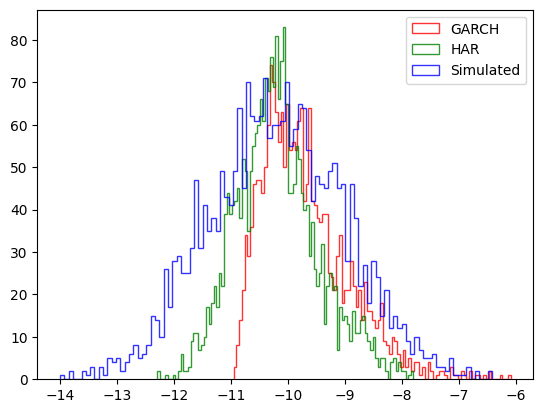

In [5]:
plt.hist(garch_lvol, bins=100, color='red', alpha=0.8, histtype='step', label='GARCH')
plt.hist(har_lvol, bins=100, color='green', alpha=0.8, histtype='step', label='HAR')
plt.hist(sim_lvol, bins=100, color='blue', alpha=0.8, histtype='step', label='Simulated')
plt.legend()
plt.show()

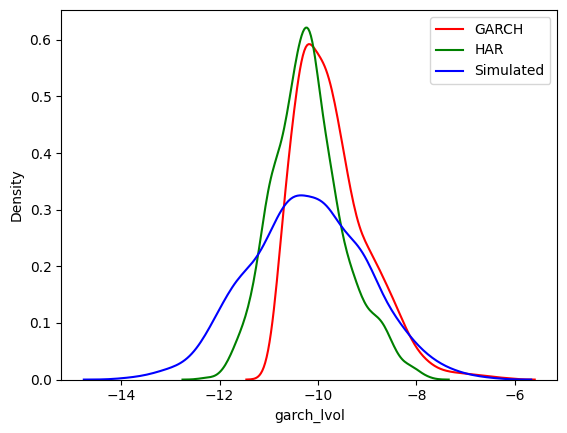

In [8]:
import seaborn as sns
sns.kdeplot(garch_lvol, color='red', label='GARCH')
sns.kdeplot(har_lvol, color='green', label='HAR')
sns.kdeplot(sim_lvol, color='blue', label='Simulated')
plt.legend()
plt.show()